# Text Classification 

- An example of supervised learning algorithm 

- We use text data and NLP methods (text vectorization) to obtain a model relating a given document to a categorical variable. 

- We use **Classification algorithms** which can be characterized by the three categories:
    
    1. **Binary classification**: 
        - The categorical variable has two values (labels). One observation can only have one value.
        
        - Example: email classified as spam/non spam

    
    2. **Multiclass classification**: 
        - Multiple labels
        
        - Each observation can only have one single value
        
    3. **Multilabel Classification**:
        - Each observation can have multiple labels
        
        - Exemple: a newspaper article can be assigned to multiple labels. 


We are going to see an example of Multiclass Classification.


In the following part, we will use:

    - NLP libraries: textacy, spaCy or NLTK
        
    - sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

## Dataset 

- A dataset of bug reports of Java Development Tools (JTD) open source project

- The dataset contains 45296 bug reports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eclipse_jdt.csv')
print(df.columns)

Index(['Unnamed: 0', 'Issue_id', 'Priority', 'Component', 'Duplicated_issue',
       'Title', 'Description', 'Status', 'Resolution', 'Version',
       'Created_time', 'Resolved_time', 'Fixing_time', 'Label'],
      dtype='object')


In [ ]:
len(df)

In [ ]:
df.sample(5)

### Description of the variables of interest in the dataset

- **Priority**: varies from P1 (most critical) to P5 (less severe)
    
- **Title**: A short description of the bug made by the user
    
- **Description**: a more detailed description of the bug
    
- Component: part of the project impacted by the bug

## Objective:

- We want to estimate a model which allow to **forecast the level of priority** according to the content of the **title** and the **description of bug**.

- **Supervised Learning**: 
    
    1. **Training phase**: Estimation of a model with the training set: training observations (title + description) and their associated labels (priority in our case)
            
            - feature engineering: selecting a adequate set of features of the training observations 
                
            
    At the end of the process we have the trained model which can be used to make predictions
            
    2. **Prediction phase**: The trained model is used with new input observations
        - This new observations are transformed in the same way as in the training phase to produce feature vectors
        - The new feature vectors are applied to the trained model to generate predictions

### Variable of interest: Priority

In [ ]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

### Comment:
- Class imbalance:
    
    - The number of bugs with priority P3 is much higher than for the other bugs priorities
    
    - The text classification algorithm will have more information for P3 than for the other priority levels 
    
    

### Distribution of the bugs by components

In [ ]:
df['Component'].value_counts()

## Devising a Text Classification Model

Four usual steps:
    
    1. Data preparation
    2. Train-Test split
    3. Training the Machine Learning Model
    4. Model evaluation

### Step 1: Data preparation

- Our aim is to predict **priority** of a bug report according to its **Title** and **Description**
- We keep the columns 'Title', 'Description' and 'Priority' and discard the other ones
- Note that by doing so we restrict our information set => The other variables of the data could countain useful information
- We drop lines with missing information
- We combine 'Title' and 'Description' to obtain a single 'text' column

In [3]:
df=df[['Title','Description','Priority']]
df=df.dropna()
df['text']= df['Title']+''+df['Description']
df=df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

##### We eliminate special characters 

In [4]:
import textacy
import textacy.preprocessing as tprep

preproc = tprep.make_pipeline(
    tprep.replace.urls,
    tprep.remove.html_tags,
    tprep.normalize.hyphenated_words,
    tprep.normalize.quotation_marks,
    tprep.normalize.unicode,
    tprep.remove.accents,
    tprep.remove.punctuation,
    tprep.normalize.whitespace,
    tprep.replace.numbers
)

In [5]:
df['clean_text']=df['text'].apply(preproc)


In [ ]:
len(df)

We eliminate texts with less than 50 characters. These descriptions have not been filled correctly. The description of the problem is not accurate. 

In [6]:
df=df[df['clean_text'].str.len()>50]

In [ ]:
print(f"Final number of bug reports: {len(df)}")

Alternative method: creating a function 

In [ ]:
def normalize(text):
    text = tprep.replace.urls(text)# we replace url with text
    text = tprep.remove.html_tags(text)
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    text = tprep.remove.punctuation(text)
    text = tprep.normalize.whitespace(text)
    text = tprep.replace.numbers(text)
    text = text.str.len()>50
    return text

In [ ]:
df['clean_text']=df['text'].apply(normalize)

In [ ]:
df.loc[25026,'text']

In [ ]:
df.loc[25026,'clean_text']

### Step 2: Training set and test set

- We split the data set into the training set and the test set 

- We use sklearn train_test_split function

1 Independant variable

2 Target variable

3 test_size = 0.2 => the test set represent 20 % of the data set, the training set 80 % 

4 random_state = 42 => influence how the rows are sampled into the train and test sets. With another number, we will obtain another 80/20 train/test set.
By fixing a value for random_state, we are able to reproduce our results. We can also compare the results when we modify (add/substract) the set of variable 

5 stratify=df['Priority'] => The distribution of the target variable is maintained in the training set and the test set

In [ ]:
df['Priority']=df['Priority'].astype('category')

In [ ]:
df.dtypes

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['clean_text'],df['Priority'], test_size=0.2,random_state=42,stratify=df['Priority'])

In [8]:
print('Size of Training Data', X_train.shape[0])
print('Size of Test Data', X_test.shape[0])

Size of Training Data 36035
Size of Test Data 9009


### Step 3: Training the Machine Learning Model

- Text classification: a supervised machine learning model
    
- Support Vector Machine: a popular algorithm used when woorking with text classification 
    
    
- other possible methods:
    1. Naive Bayes Classifier Algorithm
    2. Boosting Models 
    3. Neural Networks

#### Computation of the tf-idf on the training set


- We must transform our data of text into a numerical array before estimating the model.

- Counting words in each bug reports => combines all counts of words
    - Problem: common words will be overweighted 
        
- We represents texts with the tf-idf 


https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Here, we use the tokenizer included in TfidfVectorizer.
    
However, we can define our owns tokenizer from spaCy and/or NLTK 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2),stop_words='english')
X_train_tf=tfidf.fit_transform(X_train)

In [ ]:
X_train_tf.shape, type(X_train_tf)

In [ ]:
print(X_train_tf[0])

In [ ]:
tfidf.vocabulary_

In [ ]:

print(len(tfidf.vocabulary_))

In [ ]:
tfidf.idf_, len(tfidf.idf_)

#### Estimation of the Model SVC (Support Vector Classification)

Some parameters

- C = 1 (value by default) regularization parameter
- random_state = 0 => to obtain reproducible output across multiple function calls
- tol = tolerance for stopping criteria
- dual = auto => select the algorithm to solve either the primal or the dual of the optimization problem, in function of the n_sample, n_features, loss, ...

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore',category=FutureWarning)

In [ ]:
from sklearn.svm import LinearSVC
model1 = LinearSVC(random_state=0,tol=1e-5)
model1.fit(X_train_tf,Y_train)

### Model evaluation

In [ ]:
X_test_tf=tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)

The simplest way to estimate the model is through **accuracy score**

$$ Accuracy=\frac{Number\,of\,correct\,predictions}{Total\,number\,of\,predictions}$$

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))

- The accuracy score of the trained model is equal to 87,5 % => the model can be considerer as a good predictor

- Question: comparison of this accuracy score with other simple classifier. Does our trained model have a higher accuracy score?

### Comparison with a Simple Benchmark Model

- sklearn.dummy.DummyClassifier : make prediction that ignore the input features

- Can be used as a baseline to compare against other more complex classifiers

- The behavior of this baseline model is selected with the **strategy** parameter:
    
    - 'most_frequent' : the model always predict the most frequent class label in the target variable y . The predict_proba 
        method returns the matching one-hot encoder
    
    - "prior" : the model always predict the most frequent class label in the observed target variable. The predict_proba 
        method returns the empirical class distribution of the target variable y
    
    - "stratified" : make a random prediction for a class using the multinomial empirical class prior distribution
    
    - "uniform" : generates prediction uniformly at random from the list of unique classes observed in y. Each class has equal probability.
    
    - "constant" : always predicts a constant label provided by the user. 


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
clf=DummyClassifier(strategy="most_frequent")
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print('Acuracy Score',accuracy_score(Y_test,Y_pred_baseline))

In [ ]:
Y_pred_baseline

In [ ]:
clf.class_prior_

#### Comment
Same value of accuracy for the baseline model: the SVC model doesn't do a better job

### Naive Bayes algorithm

In [ ]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Y_train)
Test_Y = Encoder.fit_transform(Y_test)

In [ ]:
# fit the training dataset on the NB classifier
from sklearn.naive_bayes import MultinomialNB
Naive = MultinomialNB()
Naive.fit(X_train_tf,Train_Y)
# predict the labels on validation dataset
Y_pred_NB = Naive.predict(X_test_tf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Y_pred_NB, Test_Y))

## Confusion Matrix


How well the SVC model is performing for the different values of the target variable? (The different priority levels here)



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(Y_test,Y_pred)
print(cm)

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)


In [ ]:
target_names= ['P1','P2','P3','P4','P5']

https://gist.github.com/mesquita/f6beffcc2579c6f3a97c9d93e278a9f1#file-nice_cm-py

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(filename,  bbox_inches='tight')

In [ ]:
cm_analysis(Y_test,Y_pred,'confusion',target_names,model1.classes_) 

In [ ]:
from sklearn.metrics import recall_score
print(recall_score(Y_test,Y_pred, labels=target_names,average=None,zero_division=0.0))

In [ ]:
model1.classes_

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,zero_division=0.0))

- Accuracy of the model: 0.88

- Precision and Recall are good for P3 but not for the other labels => accuracy is not sufficient to understand the forecasting performance of the model.

- macro avg: (unweighted) average per label - Does not take label imbalance into account
- weighted avg: weighted average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; 



## XGBoost Classifier

In [10]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [17]:
Y_train_label = le.fit_transform(Y_train)
Y_test_label = le.fit_transform(Y_test)

In [12]:
Y_train_label[:100]

array([2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2])

In [13]:
from xgboost import XGBClassifier 
clf = XGBClassifier(random_state =42)

In [15]:
clf.fit(X_train_tf,Y_train_label)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
X_test_tf=tfidf.transform(X_test)
Y_pred = clf.predict(X_test_tf)

In [22]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
accuracy= accuracy_score(Y_test_label,Y_pred)
report = classification_report(Y_test_label,Y_pred)
print(f"accuracy: {accuracy:.2f}")
print(report)
confusion = confusion_matrix(Y_test_label, Y_pred)


accuracy: 0.88
              precision    recall  f1-score   support

           0       0.57      0.05      0.10       224
           1       0.27      0.00      0.01       608
           2       0.88      1.00      0.94      7899
           3       0.53      0.15      0.23       228
           4       0.00      0.00      0.00        50

    accuracy                           0.88      9009
   macro avg       0.45      0.24      0.26      9009
weighted avg       0.82      0.88      0.83      9009



C:\Users\ylepen\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ylepen\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ylepen\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

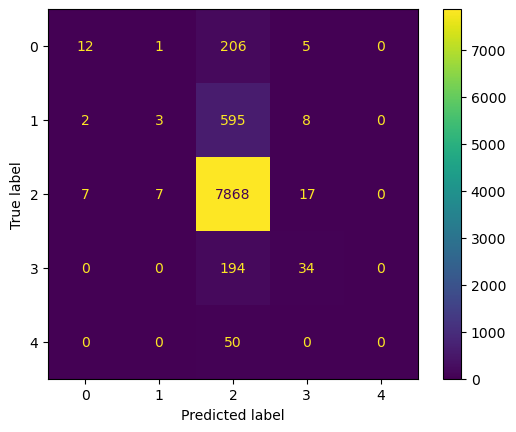

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf,X_test_tf,Y_test_label)

### Metrics for imbalanced data

In [ ]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test,Y_pred,zero_division=0))

## Dealing with Class Imbalance

- P3 is by far the most frequent label in the dataset. 
- This imbalance implies that the model is able to detect the characteristics of texts associated to P3 but much less for other labels.

- How can we handle this issue of class imbalance? 

- Two approaches:
    
    1. **upsampling**: techniques used to artificially increase the number of observations of less frequent classes
    
    2. **downsampling**: techniques used to reduce the number of observations of the majority class
        

#### An example of dowsampling beneath: Step 1 resampling the data set 
    
    1. We choose to randomly downsample the P3 class: we keep 4000 observations
    2. We create a dataframe with all other categories
    3. We concatenate the two dataframe to create a new (balanced) dataset 

In [ ]:
df_sampleP3 = df[df['Priority']=='P3'].sample(4000)
df_sampleRest = df[df['Priority']!='P3']
df_balanced = pd.concat([df_sampleP3,df_sampleRest])
df_balanced['Priority'].value_counts()

In [ ]:
df_balanced.sample(5)

#### Step 2 : simplifying and cleaning the data

In [ ]:
df_b = df_balanced[['Priority','text']]
df_b=df_b.dropna()
df_b['text'] = df['text'].apply(preproc)

In [ ]:
df_b=df_b[df_b['text'].str.len()>50]

### Step 3: train-test split

In [ ]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(df_b['text'],df_b['Priority'], test_size=0.2,random_state=42,stratify=df_b['Priority'])

In [ ]:
print('Size of Training Data', X_train_b.shape[0])
print('Size of Test Data', X_test_b.shape[0])

### Step 4: Training the ML model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_b = TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')
X_train_tf_b=tfidf_b.fit_transform(X_train_b)

In [ ]:
from sklearn.svm import LinearSVC
model1_b = LinearSVC(random_state=0,tol=1e-5)
model1_b.fit(X_train_tf_b,Y_train_b)

### Step 5: Model evaluation

In [ ]:
X_test_tf_b=tfidf_b.transform(X_test_b)
Y_pred_b = model1_b.predict(X_test_tf_b)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test_b, Y_pred_b))

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test_b,Y_pred_b)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names= ['P1','P2','P3','P4','P5']
print(classification_report(Y_test_b,Y_pred_b,zero_division=0.0))

In [ ]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test_b,Y_pred_b,zero_division=0))

## Cross-validation 

- K-fold cross-validation for the LinearSVC + full sample

In [ ]:
X_train_tf.shape, Y_train.shape

In [ ]:
from sklearn.model_selection import cross_val_score
scores= cross_val_score(estimator=model1,X=X_train_tf,y=Y_train,cv=5)

print("Validation scores from each iteration of the cross validation", scores)

print('Mean value of validation scores', scores.mean())

print('Standard deviation of validation scores', scores.std())

## Hyperparameter Tuning

- Grid Search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [ ]:
training_pipeline = Pipeline(steps=[('tfidf',TfidfVectorizer(stop_words="english")),
                             ('model', LinearSVC(random_state=42,tol=1e-5))])

In [ ]:
grid_param=[{
    'tfidf__min_df': [5,10], # ignore terms with a document frequency stricly lower than min_df
    'tfidf__ngram_range': [(1,3),(1,6)], # (1,3) unigram/bigram/trigram
    'model__penalty':['l2'], # specify the norm used in the penalization
    'model__loss': ['hinge'],
    'model__max_iter': [15000]
},{
    'tfidf__min_df': [5,10], 
    'tfidf__ngram_range': [(1,3),(1,6)],
    'model__C': [1,10],
    'model__tol': [1e-2,1e-3]
}]    

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
gridSearchProcessor=GridSearchCV(estimator=training_pipeline,param_grid=grid_param,cv=5)

In [ ]:
gridSearchProcessor.fit(X_train,Y_train)

In [ ]:
best_params=gridSearchProcessor.best_params_
print(best_params)

In [ ]:
best_results=gridSearchProcessor.best_score_ ## Mean accuracy

bestlinearSCV=gridSearchProcessor.best_estimator_

bestlinearSCV.fit(X_train,Y_train)

Y_pred=bestlinearSCV.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,zero_division=0.0))

### Unbalance/Balance sampler

In [ ]:
import imblearn

### Random over-sampling

Random sampling with replacement

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros= RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(X_train_tf,Y_train)


In [ ]:
from collections import Counter
print(sorted(Counter(Y_resampled).items()))

In [ ]:
from sklearn.svm import LinearSVC
model1_ov = LinearSVC(random_state=0,tol=1e-5)
model1_ov.fit(X_resampled,Y_resampled)

X_test_tf=tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)

from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))


In [ ]:
from sklearn.metrics import classification_report
target_names= ['P1','P2','P3','P4','P5']
print(classification_report(Y_test,Y_pred,zero_division=0.0))

In [ ]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test_b,Y_pred_b,zero_division=0))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus= RandomUnderSampler(random_state=0)
X_resampled, Y_resampled = rus.fit_resample(X_train_tf,Y_train)

### SMOTE : Synthetic Minority Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resamp, Y_resamp = SMOTE().fit_resample(X_train_tf,Y_train)
print(sorted(Counter(Y_resamp).items()))

In [ ]:
from sklearn.svm import LinearSVC
model1 = LinearSVC(random_state=0,tol=1e-5)
model1.fit(X_resamp,Y_resamp)

X_test_tf=tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)

from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))

In [ ]:
from sklearn.metrics import classification_report
target_names= ['P1','P2','P3','P4','P5']
print(classification_report(Y_test,Y_pred,zero_division=0.0))

In [ ]:
print(model1.get_params())

In [ ]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test_b,Y_pred_b,zero_division=0))

#### Gridsearch with resampling

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [ ]:

modelSVCreb = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words="english")),
    ('sampling', SMOTE()),
    ('model', LinearSVC(random_state=42,tol=1e-5,dual='auto'))
])

In [ ]:
grid_param=[{
    'tfidf__min_df': [5,10], # ignore terms with a document frequency stricly lower than min_df
    'tfidf__ngram_range': [(1,3),(1,6)], # (1,3) unigram/bigram/trigram
    'model__penalty':['l2'], # specify the norm used in the penalization
    'model__loss': ['hinge'],
    'model__max_iter': [20000]
},{
    'tfidf__min_df': [5,10], 
    'tfidf__ngram_range': [(1,3),(1,6)],
    'model__C': [1,10],
    'model__tol': [1e-2,1e-3]
}]    

In [ ]:
gridSearchP=GridSearchCV(estimator=modelSVCreb,param_grid=grid_param,cv=5)

In [ ]:
gridSearchP.fit(X_train,Y_train)

In [ ]:
best_params_P=gridSearchP.best_params_
print(best_params_P)

In [ ]:
best_results_P=gridSearchP.best_score_ ## Mean accuracy

bestlinearSCV_P=gridSearchP.best_estimator_

bestlinearSCV_P.fit(X_train,Y_train)

Y_pred=bestlinearSCV_P.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,zero_division=0.0))

In [ ]:
print(sorted(gridSearchP.cv_results_.keys()))

In [ ]:
pd.set_option('display.max_colwidth',None)
gridSearchP_results=pd.DataFrame(gridSearchP.cv_results_)
gridSearchP_results[['rank_test_score','mean_test_score','params']].sort_values(by=['rank_test_score'])[:5]